# Question 4: Backtesting

Objective: \
Demonstrate understanding of how to implement and backtest a trading strategy.

Backtest either: \
RSI or MACD strategies .
Show PnL, annualised sharpe ratio, and drawdown over time.
Make your code as effieicent (vectorized) as possible.

In [4]:
import os
from datetime import timedelta
import sqlite3
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = f'{os.pardir}/data/MarketData.csv'

metals = ['COPPER', 'ZINC']

In [5]:
# Get the data from the database
def log_execution(func):
    def wrapper(*args, **kwargs):
        if func.__name__=='get_metal_data':
            print(f"Getting data for {args[0]} from {args[1]} to {args[2]}.")
        else:
            print(f"Running function {func.__name__} with arguments: {args} and keyword arguments: {kwargs}.")
        start_execution = time.time()
        result = func(*args, **kwargs)
        end_execution = time.time()
        print(f"Finished execution of {func.__name__} in {end_execution - start_execution:.2f} seconds.\n")
        return result
    return wrapper

@log_execution
def get_metal_data(metal, start_date, end_date):
    conn = sqlite3.connect(f'{os.pardir}/market_data.db')
    cur = conn.cursor()
    cur.execute('''
        SELECT * FROM MetalPrices
        WHERE Metal = ? AND Date >= ? AND Date <= ?
        ORDER BY Date
    ''', (metal, start_date, end_date))

    df = pd.DataFrame(cur.fetchall(), columns=['Date', 'Metal', 'Price', 'MACD', 'RSI'])
    cur.close()
    conn.close()
    df['Date'] = pd.to_datetime(df['Date'])
    return df

start_date = '2020-01-01'
end_date = '2021-12-31'
df = get_metal_data('COPPER', start_date, end_date)
df

Getting data for COPPER from 2020-01-01 to 2021-12-31.
Finished execution of get_metal_data in 0.00 seconds.



,Date,Metal,Price,MACD,RSI
0,2020-01-01,COPPER,6174.0,69.634394,62.254143
1,2020-01-02,COPPER,6188.0,65.324212,63.811455
2,2020-01-03,COPPER,6129.5,56.536187,53.862378
3,2020-01-06,COPPER,6138.5,49.724644,55.018407
4,2020-01-07,COPPER,6149.0,44.658909,56.384452
...,...,...,...,...,...
518,2021-12-27,COPPER,9568.0,-2.500190,51.494312
519,2021-12-28,COPPER,9568.0,0.815513,51.494312
520,2021-12-29,COPPER,9680.5,12.378352,56.027452
521,2021-12-30,COPPER,9691.5,22.173985,56.453796


TypeError: bad operand type for unary ~: 'float'

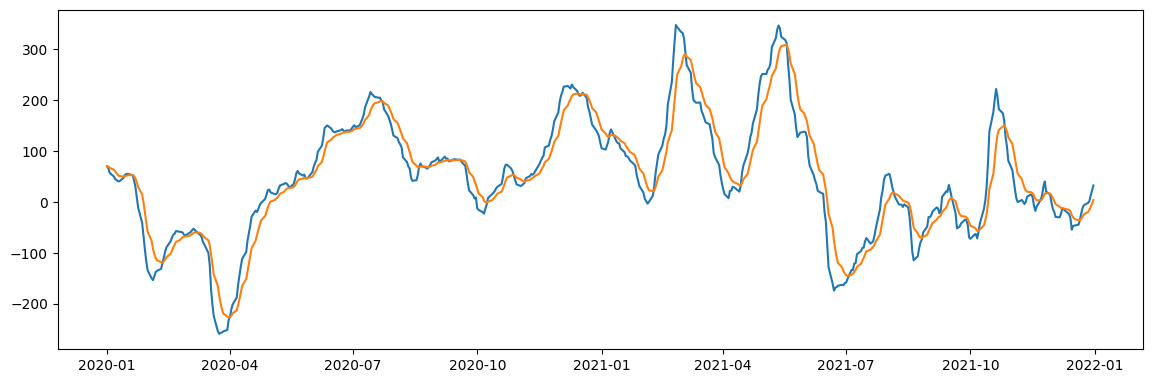

In [ ]:
fig = plt.figure(figsize=(14, 15))
grid = fig.add_gridspec(nrows=3, ncols=1)

ax = fig.add_subplot(grid[0, 0])
ax.plot(df['Date'], df['MACD'], label='MACD')
signal = df['MACD'].ewm(span=9, adjust=False).mean()
ax.plot(df['Date'], signal, label='Signal Line')
mask_MACD_above_signal = df['MACD'] > signal
mask_MACD_corsses_signal = 
ax.scatter(df['Date'][mask_MACD_corsses_signal], df['MACD'][mask_MACD_corsses_signal], color='green', label='Buy Signal')
ax.legend()
ax.set_title('MACD Indicator')

ax = fig.add_subplot(grid[1, 0])
ax.plot(df['Date'], df['Price'], label='Price', color='black')
ax.legend()
ax.set_title('Price Chart')

ax = fig.add_subplot(grid[2, 0])
ax.plot(df['Date'], df['RSI'], label='RSI')
ax.axhline(60, color='red', linestyle='--')
ax.axhline(40, color='green', linestyle='--')
ax.legend()

plt.show()

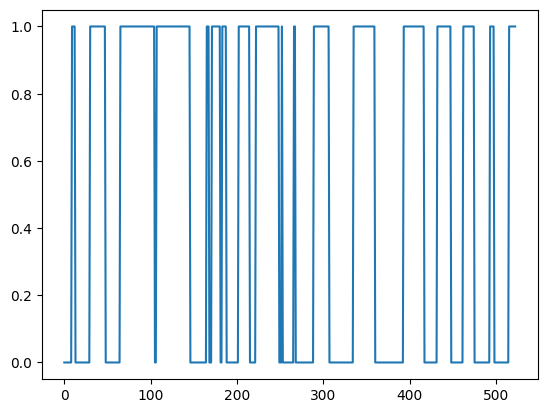

In [ ]:
# Backtest a strategy
plt.plot(mask_MACD_above_signal)